In [1]:
# Download mnist dataset
import torch
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
mnist = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)



In [2]:
def get_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    if torch.cuda.is_available(): 
        return torch.device("cuda")
    return torch.device("cpu")

device = get_device()
device

device(type='mps')

In [3]:
# Split data into training and validation sets
# Use 80% for training and 20% for validation
from torch.utils.data import random_split
train_size = int(0.8 * len(mnist))
val_size = int(0.1*len(mnist))
test_size = len(mnist) - train_size - val_size
mnist_train, mnist_val, mnist_test = random_split(mnist, [train_size, val_size, test_size])

train_data = mnist.data[mnist_train.indices]/255.0 
train_targets = mnist.targets[mnist_train.indices]

val_data = mnist.data[mnist_val.indices]/255.0
val_targets = mnist.targets[mnist_val.indices]

test_data = mnist.data[mnist_test.indices]/255.0
test_targets = mnist.targets[mnist_test.indices]

val_data, val_targets = val_data.to(device), val_targets.to(device)
test_data, test_targets = test_data.to(device), test_targets.to(device)

In [4]:
# Show the size and shape and datatype of the dataset
print("Number of training samples:", len(mnist_train))
print("Shape of each sample:", mnist.data[0].shape)
print("Number of validation samples:", len(mnist_val))
print("Data type of each sample:", mnist.data[0].dtype)
print("Data type of labels:", mnist.targets.dtype)


Number of training samples: 48000
Shape of each sample: torch.Size([28, 28])
Number of validation samples: 6000
Data type of each sample: torch.uint8
Data type of labels: torch.int64


In [5]:
# Show memory used by the dataset
# Show memory used by the dataset
print("Memory used by training set:", mnist.data.element_size() * mnist.data[mnist_train.indices].nelement() / (1024 ** 2), "MB")
print("Memory used by validation set:", mnist.data.element_size() * mnist.data[mnist_val.indices].nelement() / (1024 ** 2), "MB")

Memory used by training set: 35.888671875 MB
Memory used by validation set: 4.486083984375 MB


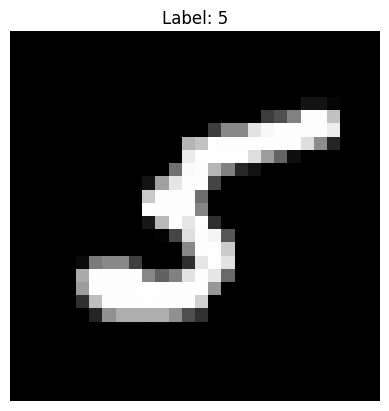

In [6]:
# Visualise a random image
import matplotlib.pyplot as plt
import numpy as np
import random
image, label = random.choice(mnist)
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

In [7]:
# Could use lightning here but we're keeping it simple so pure PyTorch.

import torch.nn as nn
import torch.nn.functional as F

class SimplestNN(torch.nn.Module):
    def __init__(self):
        super(SimplestNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = x.float()
        return self.layers(x)

In [8]:

import torch.optim as optim
model = SimplestNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model = model.to(device)




In [9]:

print("Validation batch shape:", val_data.shape)
print("Validation targets shape:", val_targets.shape)


val_outputs = model(val_data) 
val_loss = criterion(val_outputs, val_targets)
print("Validation Loss before training :", val_loss.item()) 


Validation batch shape: torch.Size([6000, 28, 28])
Validation targets shape: torch.Size([6000])
Validation Loss before training : 2.318248987197876


In [10]:
epochs = 100
for epoch in range(epochs): 
    model.eval()  # Set the model to evaluation mode
    #Validate the model
    with torch.no_grad():
        #Loop through the validation set
        val_loss = 0
        val_outputs = model(val_data) 
        val_loss = criterion(val_outputs, val_targets)
        print(f'Epoch {epoch+1}/{epochs} validation Loss: {val_loss.item():.4f}')

    model.train() # Set the model to training mode
    optimizer.zero_grad()

    permuted_indices = torch.randperm(train_data.size(0))  # Shuffle the data
    data = train_data[permuted_indices]
    target = train_targets[permuted_indices]
    batch_size=4096
    for i in range(0, data.size(0), batch_size):

        batch_data = data[i:i+batch_size].to(device)
        batch_target = target[i:i+batch_size].to(device)
        
        # Forward pass
        outputs = model(batch_data)
        loss = criterion(outputs, batch_target)
        #print(f'Epoch {epoch}/{epochs} batch {i/128} training Loss: {loss.item():.4f}')
        loss.backward()
    optimizer.step()

Epoch 1/100 validation Loss: 2.3182
Epoch 2/100 validation Loss: 2.2584
Epoch 3/100 validation Loss: 2.2015
Epoch 4/100 validation Loss: 2.1434
Epoch 5/100 validation Loss: 2.0819
Epoch 6/100 validation Loss: 2.0170
Epoch 7/100 validation Loss: 1.9493
Epoch 8/100 validation Loss: 1.8802
Epoch 9/100 validation Loss: 1.8104
Epoch 10/100 validation Loss: 1.7401
Epoch 11/100 validation Loss: 1.6699
Epoch 12/100 validation Loss: 1.6000
Epoch 13/100 validation Loss: 1.5310
Epoch 14/100 validation Loss: 1.4633
Epoch 15/100 validation Loss: 1.3977
Epoch 16/100 validation Loss: 1.3344
Epoch 17/100 validation Loss: 1.2737
Epoch 18/100 validation Loss: 1.2155
Epoch 19/100 validation Loss: 1.1598
Epoch 20/100 validation Loss: 1.1068
Epoch 21/100 validation Loss: 1.0565
Epoch 22/100 validation Loss: 1.0090
Epoch 23/100 validation Loss: 0.9644
Epoch 24/100 validation Loss: 0.9228
Epoch 25/100 validation Loss: 0.8839
Epoch 26/100 validation Loss: 0.8478
Epoch 27/100 validation Loss: 0.8142
Epoch 28/1

In [11]:
val_outputs = model(val_data)
val_loss = criterion(val_outputs, val_targets)
print("Validation Loss:", val_loss.item())

Validation Loss: 0.2898012697696686


In [12]:
test_outputs = model(test_data.to(device))
test_targets = test_targets.to(device)
# Print how many in the test set are classified incorrectly
correct_predictions = (torch.argmax(test_outputs, dim=1) == test_targets).sum().item()
total_predictions = test_targets.size(0)
incorrect_predictions = total_predictions - correct_predictions
print(f'Incorrect predictions in the test set: {incorrect_predictions} out of {total_predictions}')

Incorrect predictions in the test set: 501 out of 6000


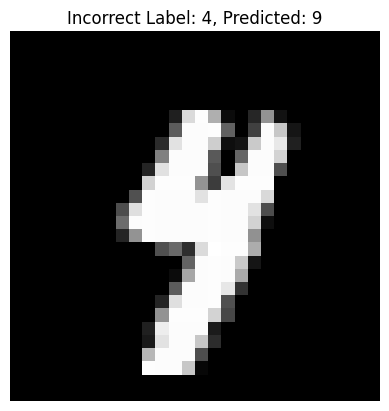

In [16]:
# Show the first incorrect prediction as an image
test_images = test_data.cpu()
incorrect_indices = (torch.argmax(test_outputs,dim=1) != test_targets).nonzero(as_tuple=True)[0]
if incorrect_indices.numel() > 0:
    first_incorrect_index = incorrect_indices[0]
    incorrect_image = test_images[first_incorrect_index]
    incorrect_label = test_targets[first_incorrect_index].item()
    predicted_label = torch.argmax(test_outputs,dim=1)[first_incorrect_index].item()

    plt.imshow(incorrect_image, cmap='gray')
    plt.title(f'Incorrect Label: {incorrect_label}, Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()